In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

In [8]:
df = pd.read_csv("/content/Unemployment in India.csv")

In [9]:
# Inspect structure
print(df.head())
print(df.info())

           Region         Date  Frequency   Estimated Unemployment Rate (%)  \
0  Andhra Pradesh   31-05-2019    Monthly                              3.65   
1  Andhra Pradesh   30-06-2019    Monthly                              3.05   
2  Andhra Pradesh   31-07-2019    Monthly                              3.75   
3  Andhra Pradesh   31-08-2019    Monthly                              3.32   
4  Andhra Pradesh   30-09-2019    Monthly                              5.17   

    Estimated Employed   Estimated Labour Participation Rate (%)   Area  
0           11999139.0                                     43.24  Rural  
1           11755881.0                                     42.05  Rural  
2           12086707.0                                     43.50  Rural  
3           12285693.0                                     43.97  Rural  
4           12256762.0                                     44.68  Rural  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data colu

In [10]:
# Convert Date column to datetime
df[' Date'] = pd.to_datetime(df[' Date'])

/tmp/ipython-input-3423740312.py:2: UserWarning: Parsing dates in  %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[' Date'] = pd.to_datetime(df[' Date'])


In [11]:
# For simplicity, let's aggregate to National Average
df_national = df.groupby(' Date')[' Estimated Unemployment Rate (%)'].mean().reset_index()

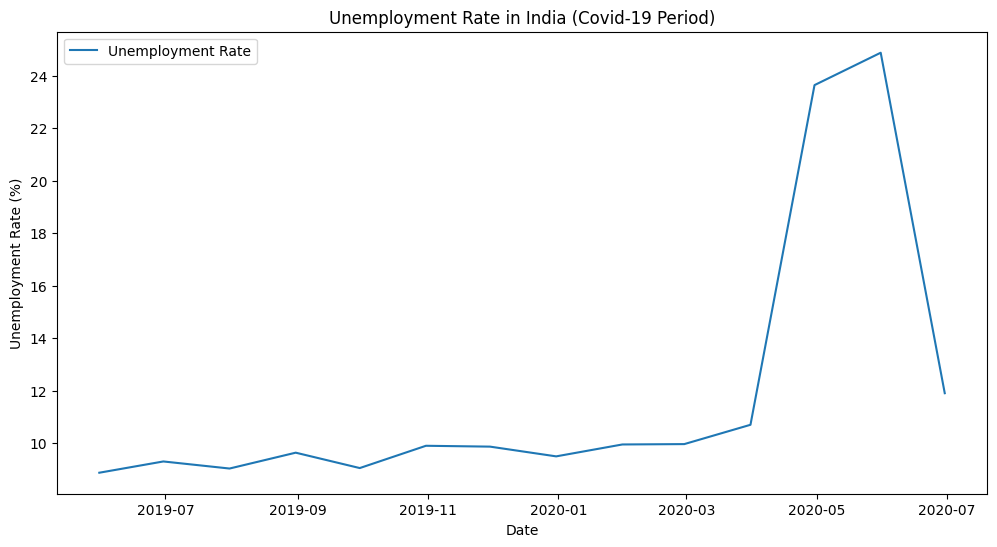

In [21]:
plt.figure(figsize=(12,6))
plt.plot(df_national[' Date'], df_national[' Estimated Unemployment Rate (%)'], label="Unemployment Rate")
plt.title("Unemployment Rate in India (Covid-19 Period)")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.legend()
plt.show()

In [20]:
# Set Date as index
ts = df_national.set_index(' Date')[' Estimated Unemployment Rate (%)']

In [14]:
# Fit ARIMA model (p,d,q) - tune these params later
model = ARIMA(ts, order=(2,1,2))
arima_res = model.fit()
print(arima_res.summary())

                                      SARIMAX Results                                       
Dep. Variable:      Estimated Unemployment Rate (%)   No. Observations:                   14
Model:                               ARIMA(2, 1, 2)   Log Likelihood                 -36.083
Date:                              Thu, 28 Aug 2025   AIC                             82.167
Time:                                      04:15:18   BIC                             84.992
Sample:                                  05-31-2019   HQIC                            81.586
                                       - 06-30-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0959     17.565      0.005      0.996     -34.330      34.522
ar.L2         -0.52

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

In [15]:
# Forecast next 12 months
forecast = arima_res.forecast(steps=12)

/tmp/ipython-input-1085982047.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(ts.index[-1], periods=12, freq="M"), forecast, label="Forecast", color="red")


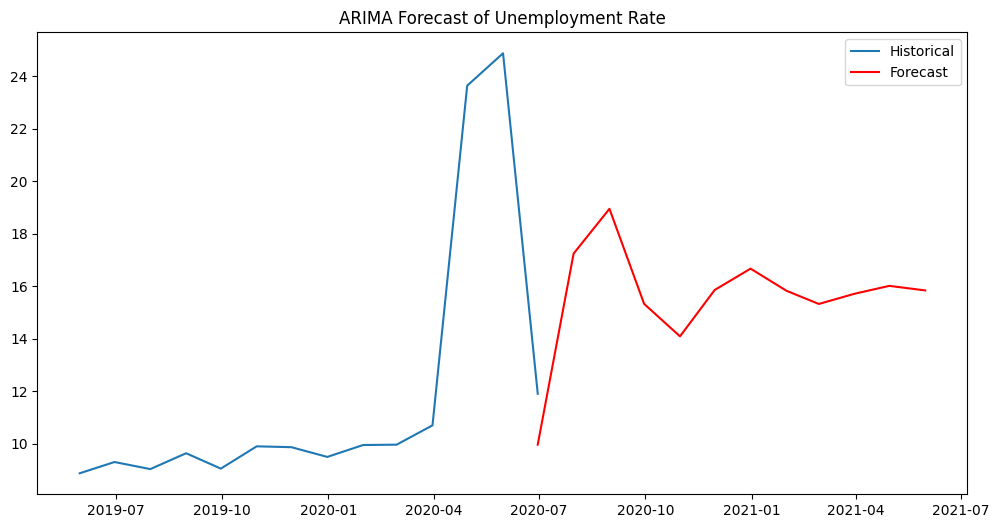

In [16]:
# Plot Forecast
plt.figure(figsize=(12,6))
plt.plot(ts, label="Historical")
plt.plot(pd.date_range(ts.index[-1], periods=12, freq="M"), forecast, label="Forecast", color="red")
plt.title("ARIMA Forecast of Unemployment Rate")
plt.legend()
plt.show()

In [18]:
df_prophet = df_national.rename(columns={" Date":"ds", " Estimated Unemployment Rate (%)":"y"})

model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=12, freq="M")
forecast = model_prophet.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf7fnn495/s8m43gvc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf7fnn495/5w6yjgh6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85140', 'data', 'file=/tmp/tmpf7fnn495/s8m43gvc.json', 'init=/tmp/tmpf7fnn495/5w6yjgh6.json', 'output', 'file=/tmp/tmpf7fnn495/prophet_modeltkfi7r01/prophet_model-20250828041646.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:16:46 - cmdstanpy - INFO - Chain [1] start processing
I

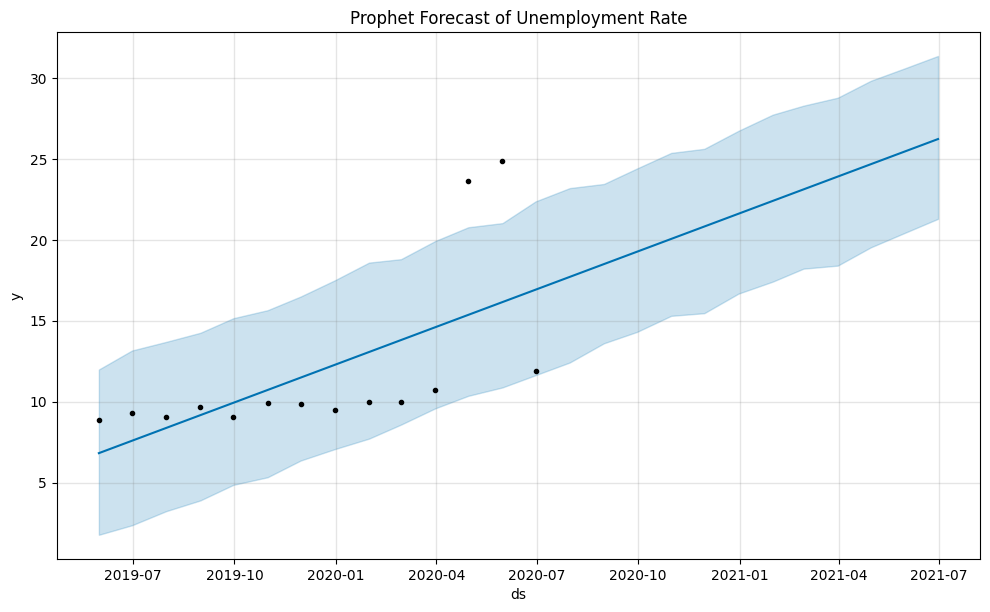

In [19]:
# Plot Prophet forecast
fig = model_prophet.plot(forecast)
plt.title("Prophet Forecast of Unemployment Rate")
plt.show()